In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import gc
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from joblib import Parallel, delayed

<h2> GridWorld Simulation </h2>

In this section, we use dynamic programming techniques on Bellman optimal equations to calculate optimal policies with value iteration. The scenario is a discounted, episodic task, in the form of a 5x5 grid matrix where row 1 column 1 is the terminal cell. Different rewards are experimented with to generate the policies for the path to be taken by an agent in the environment. Specifically, <br/>
$$v_{*}(s) = {max}_{a} \sum_{s',r} p(s',r | s,a)(r + \gamma v_{*}(s'))$$
$$\pi_{*}(s) = {argmax}_{a} \sum_{s',r} p(s',r | s,a)(r + \gamma v_{*}(s'))$$
where s is the current state, a is an action, s' is a possible successor state, and r is the reward involved. Note that $v_{*}$ is the value function and $\pi_{*}$ the policy derived from Bellman optimality equations. For dynamic programming, we greate update rules of the form:
$$v_{k+1}(s) = {max}_{a} \sum_{s',r} p(s',r | s,a)(r + \gamma v_{k}(s'))$$
with $v_{0}$ being randomly initialized and $v_{k} \to v_{*}$ as $k \to \infty$ under the GPI framework.

In [85]:
class policy(Enum):
        LEFT, RIGHT, UP, DOWN = 1, 2, 3, 4
def simulator(rewardmtrx, transitionrwd, discount, terminals, error=1e-3):
    v0, v1 = np.zeros(rewardmtrx.shape), np.zeros(rewardmtrx.shape)
    greedypol = dict()
    def is_terminal(i,j):
        return ((i,j) in terminals)
    while True:
        for i in range(v1.shape[0]):
            for j in range(v1.shape[1]):
                if is_terminal(i,j): continue
                leftval = discount*v0[i][j-1]+rewardmtrx[i][j-1] if j>0 else 0
                rightval = discount*v0[i][j+1]+rewardmtrx[i][j+1] if j<(v1.shape[1]-1) else 0
                upval = discount*v0[i-1][j]+rewardmtrx[i-1][j] if i>0 else 0
                downval = discount*v0[i+1][j]+rewardmtrx[i+1][j] if i<(v1.shape[0]-1) else 0
                values = np.array([leftval, rightval, upval, downval])+transitionrwd
                v1[i][j] = np.max(values)
                pol = policy(np.argmax(values)+1)
                if not greedypol.get(i, None):
                    greedypol[i] = dict()
                greedypol[i][j] = pol
        if (np.abs(v0-v1).max()<=error):
            break
        np.copyto(v0, v1)
    return v0, greedypol

In [86]:
def plotter(rewardmtrx, transitionrwd, discount, terminals, error=1e-3):
    val, pol = simulator(rewardmtrx, transitionrwd, discount, terminals, error)
    def is_terminal(i,j):
        return ((i,j) in terminals)
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    sns.heatmap(rewardmtrx, cmap="Blues", annot=True, fmt='.1f')
    plt.title("Rewards")
    plt.subplot(1,3,2)
    sns.heatmap(val, cmap="Blues", annot=True, fmt='.1f')
    plt.title("Optimal Value Function")
    ax = plt.subplot(1,3,3)
    plt.title("Optimal Policy")
    ax.table(cellText=np.zeros(rewardmtrx.shape, dtype='<U1'), loc='center', bbox=[0,0,1,1])
    for i in range(rewardmtrx.shape[0]):
        for j in range(rewardmtrx.shape[1]):
            if is_terminal(i, j): continue
            xlen, ylen = 1/rewardmtrx.shape[1], 1.1/rewardmtrx.shape[0]
            if pol[i][j]==policy.LEFT:
                plt.arrow(xlen*(1.2*j+0.5), ylen*(rewardmtrx.shape[0]-1.1*i-0.5), -xlen/2, 0, width=0.01)
            elif pol[i][j]==policy.RIGHT:
                plt.arrow(xlen*(1.2*j-0.25), ylen*(rewardmtrx.shape[0]-1.1*i-0.5), xlen/2, 0, width=0.01)
            elif pol[i][j]==policy.UP:
                plt.arrow(xlen*(1.2*j), ylen*(rewardmtrx.shape[0]-1.1*i-0.75), 0, ylen/2, width=0.01)
            elif pol[i][j]==policy.DOWN:
                plt.arrow(xlen*(1.2*j), ylen*(rewardmtrx.shape[0]-1.1*i), 0, -ylen/2, width=0.01)
    ax.axis("tight")
    ax.axis("off")
    plt.show()

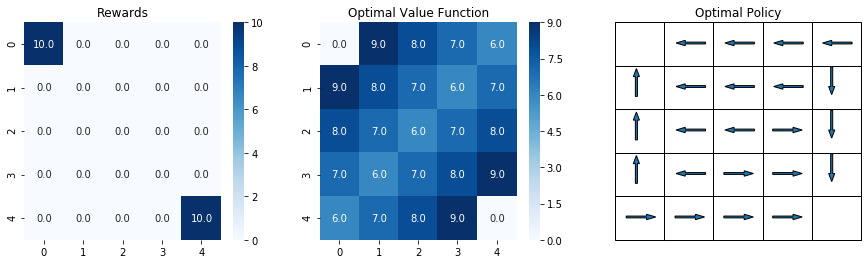

In [4]:
#Two-Terminal Cell Design
rewardmtrx = np.zeros((5,5))
rewardmtrx[0,0] = 10
rewardmtrx[4,4] = 10
transitionrwd = -1
discount = 1
plotter(rewardmtrx, transitionrwd, discount, {(0,0),(4,4)}, 1e-3)

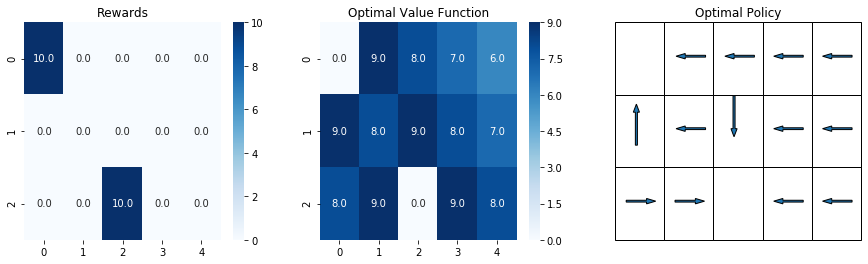

In [5]:
#Non-Symmetric Design
rewardmtrx = np.zeros((3,5))
rewardmtrx[0,0] = 10
rewardmtrx[2,2] = 10
transitionrwd = -1
discount = 1
plotter(rewardmtrx, transitionrwd, discount, {(0,0),(2,2)}, 1e-3)

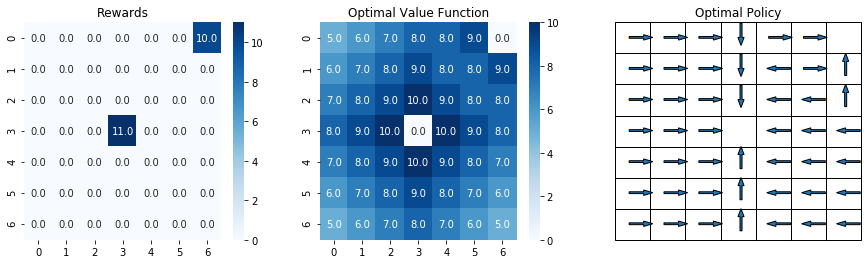

In [10]:
#Differential Terminal Conditions
rewardmtrx = np.zeros((7,7))
rewardmtrx[0,6] = 10
rewardmtrx[3,3] = 11
transitionrwd = -1
discount = 1
plotter(rewardmtrx, transitionrwd, discount, {(0,6),(3,3)}, 1e-3)

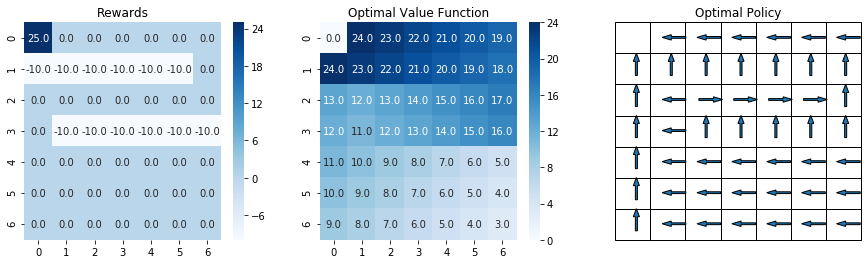

In [88]:
#Obstacle Course
rewardmtrx = np.zeros((7,7))
rewardmtrx[0,0] = 25
for i in range(6):
    rewardmtrx[1,i] = -10
for i in range(1,7):
    rewardmtrx[3,i] = -10
transitionrwd = -1
discount = 1
plotter(rewardmtrx, transitionrwd, discount, {(0,0)}, 1e-3)

<h2>Coin-Flip Gamble</h2>

Quoted from Reinforcement Learning by Richard S. Sutton and Andrew G. Barto, "A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of 100, or loses by running out of money. On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars". This is thus an episodic Markov Decision Process, where, for current capital s, the gambler would bet anywhere in $\{0,1,2,...,min(s, 100-s)\}$. We simulate optimal value functions and policies on different probabilities of achieving head.

In [89]:
def coin_flipper(winrwd, lossrwd, headp, error=1e-3):
    v0, v1 = np.zeros(101, dtype=np.int), np.zeros(101, dtype=np.int)
    greedypol = dict()
    def is_terminal(i):
        return (i==0)|(i==100)
    while True:
        for i in range(v1.shape[0]):
            if is_terminal(i): continue
            maxval, argmaxval = None, None
            for bet in range(1,min(i, 100-i)+1):
                upbet = v0[i+bet]+winrwd if i+bet==100 else v0[i+bet]
                downbet = v0[i-bet]+lossrwd if i-bet==0 else v0[i-bet]
                val = headp * upbet + (1-headp) * downbet
                if (not maxval) or (val>maxval):
                    maxval = val
                    argmaxval = bet
            v1[i] = maxval
            greedypol[i] = argmaxval
        if np.abs(v0-v1).max()<error:
            break
        np.copyto(v0, v1)
    return v0, greedypol

In [103]:
def coin_plotter(winrwd, lossrwd, headp, error=1e-3):
    val, pol = coin_flipper(winrwd, lossrwd, headp, error)
    plt.figure(figsize=(15,4))
    plt.suptitle("Head Probability = "+str(headp)+", Win Reward = "+str(winrwd)+", Loss Reward = "+str(lossrwd))
    plt.subplot(1,2,1)
    plt.title("Optimal Value Function")
    pd.Series(val)[:-1].plot()
    plt.xlabel("Current Capital")
    plt.ylabel("Optimal Value")
    plt.subplot(1,2,2)
    plt.title("Optimal Policy - Size of Bet")
    pd.Series(list(pol.values())).plot()
    plt.xlabel("Current Capital")
    plt.ylabel("Size of Optimal Bet")
    plt.show()

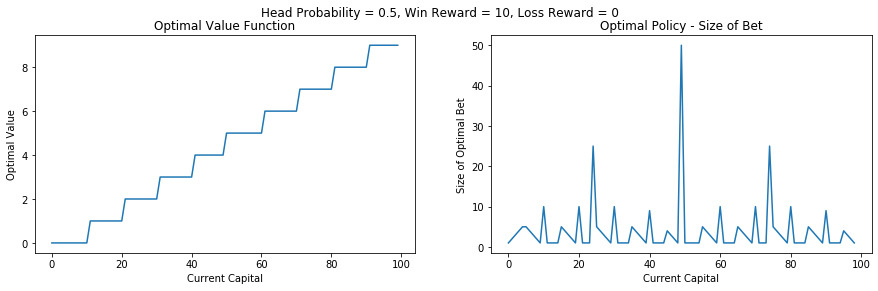

In [112]:
coin_plotter(10,0,0.5)

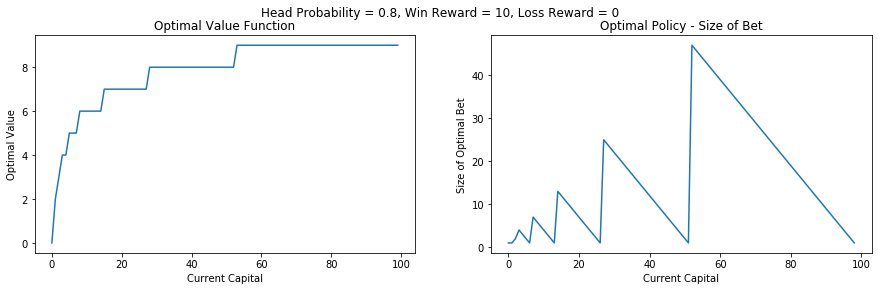

In [111]:
coin_plotter(10,0,0.8)

<h2> Stationary K-Armed Bandit Problem (UCB and Epsilon-Greedy) </h2>

In [2]:
def epsilon_helper(arms, iterations, epsilon):
    meanet, obs = np.zeros(len(arms), dtype=np.float64), np.zeros(len(arms), dtype=np.int)
    chc = np.zeros(iterations, dtype=np.int)
    for i in range(iterations):
        decision = np.random.uniform(low=0, high=1)
        armarg = np.random.choice(len(arms)) if decision<epsilon else np.argmax(meanet)
        ret = arms[armarg].rvs()
        obs[armarg]+=1
        meanet[armarg] = meanet[armarg] + 1/obs[armarg] * (ret - meanet[armarg])
        chc[i] = armarg
    return chc

In [7]:
def epsilon_greedy(arms, epsilon, knownbest):
    parallelsim, iterations = 1000, 2000
    choice = np.zeros((parallelsim, iterations), dtype=np.int)
    lst = Parallel(n_jobs=-1)(delayed(epsilon_helper)(arms, iterations, epsilon) for _ in range(parallelsim))
    for i in range(parallelsim):
        choice[i] = lst[i]
    return (choice==knownbest).sum(axis=0)/parallelsim  

In [4]:
arms = [sp.stats.norm(loc=1, scale=1), sp.stats.norm(loc=3, scale=0.5), sp.stats.norm(loc=10, scale=10),
       sp.stats.norm(loc=8, scale=0.1)]
val = epsilon_greedy(arms, 0.1, 2)

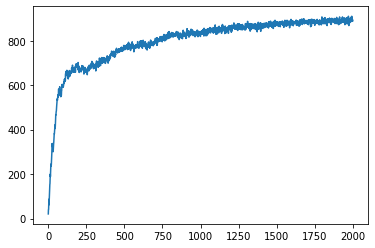

In [6]:
pd.Series(val).plot()